In [ ]:
## READ IN TRAINING DATA ##

import pandas as pd

df = pd.read_csv('../data/train.csv', header=0)

df_edit = df.copy()

In [2]:
## REMOVE/REPLACE MISSING OR NaN VALUES ##
# Age, Cabin and Embarked all have at least one NaN value

import numpy as np

# Create new numerical mapping of Sex, Gender
df_edit['Gender'] = df['Sex'].map({'female': 0, 'male': 1}).astype(int)

# Assign missing Age based on median ages of Gender and Class
median_ages = np.zeros((2,3)) # make new table for median ages for each gender and class
for i in range(0, 2):
    for j in range(0, 3):
        median_ages[i,j] = df_edit[(df_edit['Gender'] == i) & (df_edit['Pclass'] == j+1)]['Age'].dropna().median()

for i in range(0, 2):
    for j in range(0, 3):
        df_edit.loc[(df_edit['Age'].isnull()) & (df_edit['Gender'] == i) & (df_edit['Pclass'] == j+1), 'Age'] = median_ages[i,j]

# Assign missing Fare based on median Fare for each class
median_fares = [0,0,0]
for i in range(0,3):
    median_fares[i] = df_edit[(df_edit['Pclass'] == i+1)]['Fare'].dropna().median()
    
for i in range(0,3):
    df_edit.loc[(df_edit['Fare'].isnull()) & (df_edit['Pclass'] == i+1), 'Fare'] = median_fares[i]  

# Assign missing Cabin as unknown indicator "X0"
df_edit['Cabin'][df_edit['Cabin'].isnull()] = 'X0'

# Assign missing Embarked most common port (Southampton)
df_edit['Embarked'][df_edit['Embarked'].isnull()] = df['Embarked'].dropna().mode().values

-c:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
-c:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [3]:
## VARIABLE MANAGEMENT AND DERIVATION ##

import re

# Create new numerical mapping of Embarked, Port
df_edit['Port'] = df_edit['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})

# Create new variable based on Cabin, CabinLetter and numerical mapping
df_edit['CabinLetter'] = df_edit['Cabin'].str.extract('([a-zA-Z]+)')
df_edit['CabinLetter'] = df_edit['CabinLetter'].map({'X': 0, 'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'T': 8})

# Create new variable CabinNo (Cabin number)
df_edit['CabinNo'] = df['Cabin'].str.extract('([0-9]+)')
df_edit['CabinNo'][df_edit['CabinNo'].isnull()] = 0
df_edit['CabinNo'] = df_edit['CabinNo'].map(lambda x: int(x))

# Create five new FareBin variable values
def bucket(x):
    if (x>50):
        return int(5)
    else:
        return int(x/10)

df_edit['FareBin'] = df['Fare'].map(lambda x: bucket(x))

# Create new variable based on Name, NameCount
df_edit['NameCount'] = df['Name'].map(lambda x: len(re.split(' ', x)))

# Create new variable Title, from Name and convert to integer
df_edit['Title'] = df['Name'].map(lambda x: re.compile(', (.*?)\.').findall(x)[0])

df_edit['Title'][df_edit['Title'] == 'Jonkheer'] = 'Master'
df_edit['Title'][df_edit['Title'].isin(['Ms','Mlle'])] = 'Miss'
df_edit['Title'][df_edit['Title'] == 'Mme'] = 'Mrs'
df_edit['Title'][df_edit['Title'].isin(['Capt', 'Don', 'Major', 'Col', 'Sir'])] = 'Sir'
df_edit['Title'][df_edit['Title'].isin(['Dona', 'Lady', 'the Countess'])] = 'Lady'

df_edit['Title'] = pd.factorize(df_edit['Title'])[0]

# Create new variable based on SibSp and Parch, FamilySize
df_edit['FamilySize'] = df['SibSp'] + df['Parch']

-c:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
-c:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
-c:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
-c:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
-c:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats i

In [4]:
## COMBINE A COUPLE OF FEATURES ##

df_edit['Age*Class'] = df_edit['Age'] * df_edit['Pclass']
df_edit['CabinLetter*No'] = df_edit['CabinLetter'] * df_edit['CabinNo']
df_edit['Cabin*Fare'] = df_edit['CabinLetter*No'] * df_edit['Fare']
df_edit['FamilySize*Fare'] = df_edit['FamilySize'] * df_edit['Fare']

In [5]:
## DROP ALL OBJECT FEATURES AND SCALE ##

from sklearn import preprocessing

df_reduced = df_edit.copy()

df_reduced = df_reduced.drop(['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked'], axis=1)

scaler = preprocessing.StandardScaler()
for col in df_reduced:
    if col!='PassengerId' and col!='Survived':
        df_reduced[col] = scaler.fit_transform(df_reduced[col])

/opt/anaconda/envs/np18py27-1.9/lib/python2.7/site-packages/sklearn/utils/validation.py:498: UserWarning: StandardScaler assumes floating point values as input, got int64
  "got %s" % (estimator, X.dtype))


In [6]:
## MODEL USING RANDOM FOREST CLASSIFIER ON TRAINING DATA ##

from sklearn.ensemble import RandomForestClassifier

df_ready = df_reduced.copy()

# Split data into thirds to create three tests
df_third1 = df_ready[:297]
df_third2 = df_ready[297:594]
df_third3 = df_ready[594:]

df_train1 = pd.concat([df_third2, df_third3])
df_train2 = pd.concat([df_third1, df_third3])
df_train3 = pd.concat([df_third1, df_third2])

# Test 1: Train on thirds 2, 3, test on third 1
forest = RandomForestClassifier(n_estimators = 1000)
forest = forest.fit(df_train1.values[0::,2::], df_train1.values[0::,1])
output1 = forest.predict(df_third1.values[0::,2::])

# Test 2: Train on thirds 1, 3, test on third 2
forest = RandomForestClassifier(n_estimators = 1000)
forest = forest.fit(df_train2.values[0::,2::], df_train2.values[0::,1])
output2 = forest.predict(df_third2.values[0::,2::])

# Test 3: Train on thirds 1, 2, test on third 3
forest = RandomForestClassifier(n_estimators = 1000)
forest = forest.fit(df_train3.values[0::,2::], df_train3.values[0::,1])
output3 = forest.predict(df_third3.values[0::,2::])

In [7]:
## CALCULATE SCORE ##

from sklearn.metrics import f1_score

df_pred1 = pd.DataFrame(output1, columns=['Prediction'])
df_pred2 = pd.DataFrame(output2, columns=['Prediction'])
df_pred2.index += 297
df_pred3 = pd.DataFrame(output3, columns=['Prediction'])
df_pred3.index += 594

df_pred1['Survived'] = df_third1['Survived']
df_pred2['Survived'] = df_third2['Survived']
df_pred3['Survived'] = df_third3['Survived']

df_pred1['Correct'] = df_pred1['Prediction'] == df_pred1['Survived']
df_pred2['Correct'] = df_pred2['Prediction'] == df_pred2['Survived']
df_pred3['Correct'] = df_pred3['Prediction'] == df_pred3['Survived']

score = (df_pred1['Correct'].sum() + df_pred2['Correct'].sum() + df_pred3['Correct'].sum()) / 891.0
print score

df_fullpred = pd.concat([df_pred1, df_pred2, df_pred3])
print f1_score(df_fullpred['Prediction'].values, df_fullpred['Survived'].values)

0.82379349046
0.763197586727


In [8]:
## PRINCIPAL COMPONENT ANALYSIS ##

from sklearn.decomposition import PCA

features_list = df_ready.columns.values[2::]
X = df_ready.values[0::,2::]
y = df_ready.values[0::,1]

# Minimum percentage of variance we want to be described by the resulting transformed components
variance_pct = .95
 
# Create PCA object
pca = PCA(n_components=variance_pct)
 
# Transform the initial features
X_transformed = pca.fit_transform(X,y)
 
# Create a data frame from the PCA'd data
df_pca = df_ready.copy()
df_pca = df_pca.drop(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Gender', 'Port', 'CabinLetter', 'CabinNo', 'FareBin', 'NameCount', 'Title', 'FamilySize', 'Age*Class', 'Cabin*Fare', 'FamilySize*Fare', 'CabinLetter*No'], axis=1)
df_pca = pd.concat([df_pca, pd.DataFrame(X_transformed)], axis=1)

print df_pca.shape[1], " components describe ", str(variance_pct)[2:], "% of the variance"

13  components describe  95 % of the variance



17 Important features(> 0 % of max importance):
['Pclass' 'Age' 'SibSp' 'Parch' 'Fare' 'Gender' 'Port' 'CabinLetter'
 'CabinNo' 'FareBin' 'NameCount' 'Title' 'FamilySize' 'Age*Class'
 'CabinLetter*No' 'Cabin*Fare' 'FamilySize*Fare']

Features sorted by importance (DESC):
['Title' 'Gender' 'Fare' 'Age*Class' 'Age' 'NameCount' 'FamilySize*Fare'
 'Pclass' 'Cabin*Fare' 'FamilySize' 'CabinLetter*No' 'FareBin' 'CabinNo'
 'Port' 'SibSp' 'CabinLetter' 'Parch']


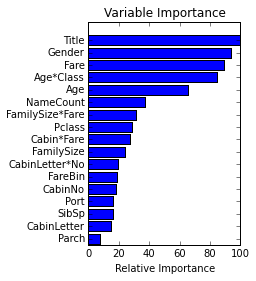

In [9]:
## INSPECT FEATURE IMPORTANCE ##

import matplotlib.pyplot as plt

#features_list = df_pca.columns.values[2::]
#X = df_pca.values[0::,2::]
#y = df_pca.values[0::,1]

features_list = df_ready.columns.values[2::]
X = df_ready.values[0::,2::]
y = df_ready.values[0::,1]
 
# Fit a random forest with (mostly) default parameters to determine feature importance
forest = RandomForestClassifier(oob_score=True, n_estimators=1000)
forest.fit(X, y)
feature_importance = forest.feature_importances_
 
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
 
# A threshold below which to drop features from the final data set. Specifically, this number represents
# the percentage of the most important feature's importance value
fi_threshold = 0
 
# Get the indexes of all features over the importance threshold
important_idx = np.where(feature_importance > fi_threshold)[0]
 
# Create a list of all the feature names above the importance threshold
important_features = features_list[important_idx]
print "\n", important_features.shape[0], "Important features(>", fi_threshold, "% of max importance):\n", \
        important_features
 
# Get the sorted indexes of important features
sorted_idx = np.argsort(feature_importance[important_idx])[::-1]
print "\nFeatures sorted by importance (DESC):\n", important_features[sorted_idx]
 
# Adapted from http://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_regression.html
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[important_idx][sorted_idx[::-1]], align='center')
plt.yticks(pos, important_features[sorted_idx[::-1]])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.draw()
plt.show()
 
# Remove non-important features from the feature set, and reorder those remaining
X = X[:, important_idx][:, sorted_idx]

In [10]:
## DOES DROPPING LOW-IMPORTANCE VARIABLES CHANGE ACCURACY? ##
## (PCA REDUCES ACCURACY FOR RANDOM FOREST CLASSIFIER.)
## (REMOVING RANDOM FOREST LOW IMPORTANCE VARIABLES MAKES LITTLE-TO-NO CHANGE)

df_reduced2 = df_ready.copy() #df_pca.copy()
df_reduced2 = df_reduced2.drop(['CabinNo', 'CabinLetter', 'Port', 'SibSp', 'Parch'], axis=1)

# Split data into thirds to create three tests
df_third1 = df_reduced2[:297]
df_third2 = df_reduced2[297:594]
df_third3 = df_reduced2[594:]

df_train1 = pd.concat([df_third2, df_third3])
df_train2 = pd.concat([df_third1, df_third3])
df_train3 = pd.concat([df_third1, df_third2])

# Test 1: Train on thirds 2, 3, test on third 1
forest = RandomForestClassifier(n_estimators = 1000)
forest = forest.fit(df_train1.values[0::,2::], df_train1.values[0::,1])
output1 = forest.predict(df_third1.values[0::,2::])

# Test 2: Train on thirds 1, 3, test on third 2
forest = RandomForestClassifier(n_estimators = 1000)
forest = forest.fit(df_train2.values[0::,2::], df_train2.values[0::,1])
output2 = forest.predict(df_third2.values[0::,2::])

# Test 3: Train on thirds 1, 2, test on third 3
forest = RandomForestClassifier(n_estimators = 1000)
forest = forest.fit(df_train3.values[0::,2::], df_train3.values[0::,1])
output3 = forest.predict(df_third3.values[0::,2::])

df_pred1 = pd.DataFrame(output1, columns=['Prediction'])
df_pred2 = pd.DataFrame(output2, columns=['Prediction'])
df_pred2.index += 297
df_pred3 = pd.DataFrame(output3, columns=['Prediction'])
df_pred3.index += 594

df_pred1['Survived'] = df_third1['Survived']
df_pred2['Survived'] = df_third2['Survived']
df_pred3['Survived'] = df_third3['Survived']

df_pred1['Correct'] = df_pred1['Prediction'] == df_pred1['Survived']
df_pred2['Correct'] = df_pred2['Prediction'] == df_pred2['Survived']
df_pred3['Correct'] = df_pred3['Prediction'] == df_pred3['Survived']

score = (df_pred1['Correct'].sum() + df_pred2['Correct'].sum() + df_pred3['Correct'].sum()) / 891.0
print score

df_fullpred = pd.concat([df_pred1, df_pred2, df_pred3])
print f1_score(df_fullpred['Prediction'].values, df_fullpred['Survived'].values)

0.82379349046
0.765321375187


In [11]:
## HYPERPARAMETER OPTIMISATION ##

from sklearn.grid_search import GridSearchCV
from operator import itemgetter

features_list = df_reduced2.columns.values[2::]
X = df_reduced2.values[0::,2::]
y = df_reduced2.values[0::,1]

# Utility function to report optimal parameters
# (adapted from http://scikit-learn.org/stable/auto_examples/randomized_search.html)
def report(grid_scores, n_top=5):
    params = None
    top_scores = sorted(grid_scores, key=itemgetter(1), reverse=True)[:n_top]
    for i, score in enumerate(top_scores):
        print("Parameters with rank: {0}".format(i + 1))
        print("Mean validation score: {0:.4f} (std: {1:.4f})".format(
              score.mean_validation_score, np.std(score.cv_validation_scores)))
        print("Parameters: {0}".format(score.parameters))
        print("")
        
        if params == None:
            params = score.parameters
    
    return params

# The most common value for the max number of features to look at in each split is sqrt(# of features)
sqrtfeat = np.ceil(np.sqrt(X.shape[1])).astype(int)

# Simple grid test (162 combinations)
grid_test1 = { "n_estimators"      : [1000],
               "max_features"      : [sqrtfeat-1, sqrtfeat, sqrtfeat+1],
               "max_depth"         : [5, 10, 25],
               "min_samples_split" : [2, 5, 10] }

forest = RandomForestClassifier(oob_score=True)

print "Hyperparameter optimization using GridSearchCV..."
grid_search = GridSearchCV(forest, grid_test1, n_jobs=-1, cv=10)
grid_search.fit(X, y)
best_params_from_grid_search = report(grid_search.grid_scores_)

Hyperparameter optimization using GridSearchCV...
Parameters with rank: 1
Mean validation score: 0.8451 (std: 0.0389)
Parameters: {'max_features': 3, 'min_samples_split': 2, 'n_estimators': 1000, 'max_depth': 10}

Parameters with rank: 2
Mean validation score: 0.8451 (std: 0.0398)
Parameters: {'max_features': 4, 'min_samples_split': 2, 'n_estimators': 1000, 'max_depth': 10}

Parameters with rank: 3
Mean validation score: 0.8429 (std: 0.0392)
Parameters: {'max_features': 5, 'min_samples_split': 2, 'n_estimators': 1000, 'max_depth': 10}

Parameters with rank: 4
Mean validation score: 0.8418 (std: 0.0364)
Parameters: {'max_features': 5, 'min_samples_split': 5, 'n_estimators': 1000, 'max_depth': 10}

Parameters with rank: 5
Mean validation score: 0.8406 (std: 0.0375)
Parameters: {'max_features': 4, 'min_samples_split': 5, 'n_estimators': 1000, 'max_depth': 10}



In [12]:
## DOES THIS IMPROVE SCORE? ##
## YES, AT LEAST ON TRAINING DATA!

from sklearn.metrics import f1_score

# Split data into thirds to create three tests
df_third1 = df_reduced2[:297]
df_third2 = df_reduced2[297:594]
df_third3 = df_reduced2[594:]

df_train1 = pd.concat([df_third2, df_third3])
df_train2 = pd.concat([df_third1, df_third3])
df_train3 = pd.concat([df_third1, df_third2])

# Test 1: Train on thirds 2, 3, test on third 1
forest = RandomForestClassifier(n_estimators=1000, max_features=4, min_samples_split=2, max_depth=10)
forest = forest.fit(df_train1.values[0::,2::], df_train1.values[0::,1])
output1 = forest.predict(df_third1.values[0::,2::])

# Test 2: Train on thirds 1, 3, test on third 2
forest = RandomForestClassifier(n_estimators=1000, max_features=4, min_samples_split=2, max_depth=10)
forest = forest.fit(df_train2.values[0::,2::], df_train2.values[0::,1])
output2 = forest.predict(df_third2.values[0::,2::])

# Test 3: Train on thirds 1, 2, test on third 3
forest = RandomForestClassifier(n_estimators=1000, max_features=4, min_samples_split=2, max_depth=10)
forest = forest.fit(df_train3.values[0::,2::], df_train3.values[0::,1])
output3 = forest.predict(df_third3.values[0::,2::])

df_pred1 = pd.DataFrame(output1, columns=['Prediction'])
df_pred2 = pd.DataFrame(output2, columns=['Prediction'])
df_pred2.index += 297
df_pred3 = pd.DataFrame(output3, columns=['Prediction'])
df_pred3.index += 594

df_pred1['Survived'] = df_third1['Survived']
df_pred2['Survived'] = df_third2['Survived']
df_pred3['Survived'] = df_third3['Survived']

df_pred1['Correct'] = df_pred1['Prediction'] == df_pred1['Survived']
df_pred2['Correct'] = df_pred2['Prediction'] == df_pred2['Survived']
df_pred3['Correct'] = df_pred3['Prediction'] == df_pred3['Survived']

score = (df_pred1['Correct'].sum() + df_pred2['Correct'].sum() + df_pred3['Correct'].sum()) / 891.0
print score

df_fullpred = pd.concat([df_pred1, df_pred2, df_pred3])
print f1_score(df_fullpred['Prediction'].values, df_fullpred['Survived'].values)

0.833894500561
0.775075987842


ROC AUC: 0.89


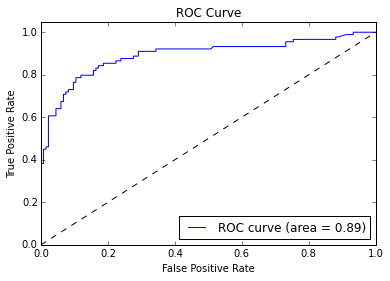

In [17]:
## ROC CURVE ##

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import train_test_split
 
# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25)
forest.fit(X_train, y_train)
 
# Determine the false positive and true positive rates
fpr, tpr, _ = roc_curve(y_test, forest.predict_proba(X_test)[:,1])
 
# Calculate the AUC
roc_auc = auc(fpr, tpr)
print 'ROC AUC: %0.2f' % roc_auc
 
# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [14]:
## SVM ##

from sklearn import svm
from sklearn.metrics import f1_score

# Split data into thirds to create three tests
df_third1 = df_reduced2[:297]
df_third2 = df_reduced2[297:594]
df_third3 = df_reduced2[594:]

df_train1 = pd.concat([df_third2, df_third3])
df_train2 = pd.concat([df_third1, df_third3])
df_train3 = pd.concat([df_third1, df_third2])

# Test 1: Train on thirds 2, 3, test on third 1
clf = svm.SVC(probability=True)
clf = clf.fit(df_train1.values[0::,2::], df_train1.values[0::,1])
output1 = clf.predict(df_third1.values[0::,2::])

# Test 2: Train on thirds 1, 3, test on third 2
clf = svm.SVC()
clf = clf.fit(df_train2.values[0::,2::], df_train2.values[0::,1])
output2 = clf.predict(df_third2.values[0::,2::])

# Test 3: Train on thirds 1, 2, test on third 3
clf = svm.SVC(probability=True)
clf = clf.fit(df_train3.values[0::,2::], df_train3.values[0::,1])
output3 = clf.predict(df_third3.values[0::,2::])

df_pred1 = pd.DataFrame(output1, columns=['Prediction'])
df_pred2 = pd.DataFrame(output2, columns=['Prediction'])
df_pred2.index += 297
df_pred3 = pd.DataFrame(output3, columns=['Prediction'])
df_pred3.index += 594

df_pred1['Survived'] = df_third1['Survived']
df_pred2['Survived'] = df_third2['Survived']
df_pred3['Survived'] = df_third3['Survived']

df_pred1['Correct'] = df_pred1['Prediction'] == df_pred1['Survived']
df_pred2['Correct'] = df_pred2['Prediction'] == df_pred2['Survived']
df_pred3['Correct'] = df_pred3['Prediction'] == df_pred3['Survived']

score = (df_pred1['Correct'].sum() + df_pred2['Correct'].sum() + df_pred3['Correct'].sum()) / 891.0
print score

df_fullpred = pd.concat([df_pred1, df_pred2, df_pred3])
print f1_score(df_fullpred['Prediction'].values, df_fullpred['Survived'].values)

0.820426487093
0.755351681957


ROC AUC: 0.84


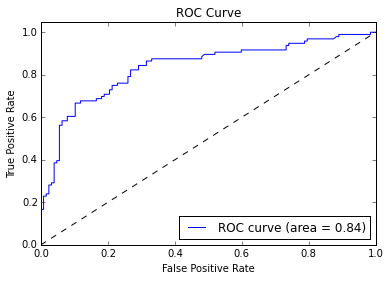

In [15]:
## ROC CURVE (SVM) ##

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import train_test_split

X = df_ready.values[0::,2::]
y = df_ready.values[0::,1]
 
# shuffle and split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25)
clf.fit(X_train, y_train)
 
# Determine the false positive and true positive rates
fpr, tpr, _ = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
 
# Calculate the AUC
roc_auc = auc(fpr, tpr)
print 'ROC AUC: %0.2f' % roc_auc
 
# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()